# Converting Dataframes to PyTrees

Numpyro models expect data in the form of a `pytrees`: nested lists or dictionaries of multidimensional arrays. But datasets usually don't start that way: we usually start by processing them as a `DataFrame`. How do we convert one representation to another?

Let's make this more concrete. Consider the following dataset:

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
import numpyro
numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro import handlers
import pandas as pd
import numpy as np
import pyro_util
import arviz as az

In [22]:
df = pd.DataFrame({'a': [1,2,1,2,1], 'b': [0,0,1,1,2], 'c': np.random.randn(5), 'd': np.random.randn(5)})

In [23]:
df

,a,b,c,d
0,1,0,-0.006010,-0.364595
1,2,0,-0.065718,-0.680357
2,1,1,-1.602073,-0.677900
3,2,1,0.216857,-0.128295
4,1,2,-1.128998,1.151890


Let's say we assume that there's a different latent mean for each value of $a$. We might write the following plated model:

In [24]:
def model(c, d, mask):
    with numpyro.plate("a", 2):
        means = numpyro.sample("mu", dist.Normal(0, 10))
        with numpyro.plate("b", 3):
            numpyro.sample("c", dist.Normal(means, 1), obs=c, obs_mask=mask)
            numpyro.sample("d", dist.Normal(means, 1), obs=d, obs_mask=mask)

But we don't have the `c`, `d`, and `mask` tensors needed for this model yet. We have to convert the dataframe into the appropriate pair of multidimensional arrays. 

First, we can group the dataframe by the plate names.

In [25]:
cols = ['c', 'd']

In [26]:
plates = ['a', 'b']

In [27]:
grouped = df.groupby(plates)[cols].first()

Next, we have to add `NaN` entries to the dataframe to give it a full rectangular shape.

In [28]:
gdf = grouped.reindex(index=pd.MultiIndex.from_product(grouped.index.levels))

In [29]:
gdf

c         d
a b                    
1 0 -0.006010 -0.364595
  1 -1.602073 -0.677900
  2 -1.128998  1.151890
2 0 -0.065718 -0.680357
  1  0.216857 -0.128295
  2       NaN       NaN

Now, we can reshape the dataframe's values into a multidimensional array. 

In [30]:
reshaped = np.reshape(gdf.values, (*gdf.index.levshape, len(cols)))

Finally, we can split the array into the two columns we need. 

In [31]:
list(reshaped.transpose())

[array([[-0.00601012, -0.06571758],
        [-1.60207272,  0.21685683],
        [-1.12899816,         nan]]),
 array([[-0.36459546, -0.68035653],
        [-0.67789992, -0.12829523],
        [ 1.15189047,         nan]])]

We can generate the `obs_mask` for numpyro by checking for nan values. Together, this gives us the functions below (which also handle the special case of a single group).

In [32]:
def to_tensor(df: pd.DataFrame, cols: list[str], groups: list[str]):
    """Convert `df` to a tensor for which every dimension but the last enumerates possible values
    of a different covariate in `groups`. Also returns the associated index.
    """
    gdf = df.groupby(groups)[cols].first()
    if len(groups) > 1:
        ix = pd.MultiIndex.from_product(gdf.index.levels)
        gdf = gdf.reindex(index=ix)
        shape = gdf.index.levshape
    else:
        shape = gdf.index.shape
    return np.reshape(gdf.values, (*shape, -1)), gdf.index

In [33]:
def to_pytree(df: pd.DataFrame, cols: list[str], groups: list[str]):
    """Convert `df` into a list of multidimensional arrays: one per element of
   `cols`. The dimensions of each result tensor enumerate over possible values of
   the index variables in `groups`. The final element of the returned list is a
   mask picking out values in the original dataframe. This is useful when specifying
   `obs` and `obs_mask` in `numpyro.sample` statements.
   """
    reshaped, _ = to_tensor(df, cols, groups)
    results = list(reshaped.transpose())
    results.append(~np.isnan(results[0]))
    return results

Using it looks like this:

In [34]:
to_pytree(df, cols, plates)

[array([[-0.00601012, -0.06571758],
        [-1.60207272,  0.21685683],
        [-1.12899816,         nan]]),
 array([[-0.36459546, -0.68035653],
        [-0.67789992, -0.12829523],
        [ 1.15189047,         nan]]),
 array([[ True,  True],
        [ True,  True],
        [ True, False]])]

In [35]:
mcmc = pyro_util.fit_nuts(model, *to_pytree(df, cols, plates))

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [36]:
result = az.from_numpyro(mcmc)

As expected, the posterior values of `mu` center around zero.

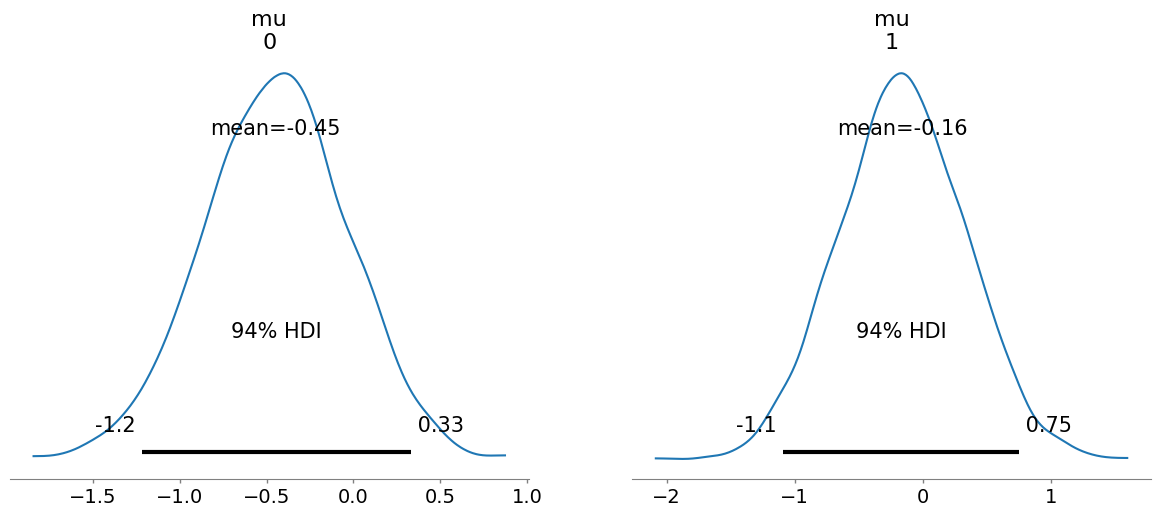

In [37]:
az.plot_posterior(result, var_names=['mu']);

For future posts, I'll be importing this `to_pytree` function from my `pyro_util` module. 